# Regresión II: No entiendo lo que dicen
_Santiago Linares & Paula lorena López_

Debido al COVID-19, las teleconferencias son ahora mucho más comunes. Sin embargo, muchas veces el ruido de fondo no permite entender que es lo que una persona ha dicho, lo que ocaciona demoras en las reuniones. Por lo tanto, utilizando redes neuronales, desarrollamos un sistema que mejore el audio, en donde sea capaz de reducir el ruido de fondo de las señales que se estén procesando.

- En primer lugar, creamos una base de datos de señales de personas hablando y de tres diferentes ruidos de fondo (ruido blanco, lluvia y tráfico). Dado que la señal tiene dos canales, extraemos la frecuencia del primer canal.  

In [2]:
import os, wave, random
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io.wavfile as waves
import tensorflow
from playsound import playsound
import simpleaudio as sa
from tensorflow import keras
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras import regularizers
from scipy.fftpack import fft, ifft
from sklearn.preprocessing import scale

En sonidos, se guardarán las frecuencias de cada uno de los audios recolectados para la base de datos. Esto consiste en leer cad audio guardado en la carpeta de audios y guardar la frecuencia de cada una.


_Los audios recolectados están guadados con formato **.wav**_

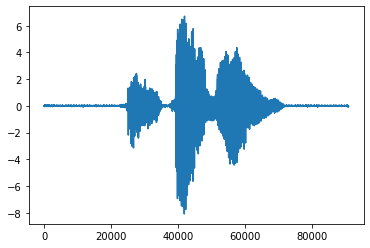

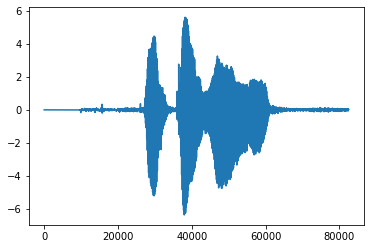

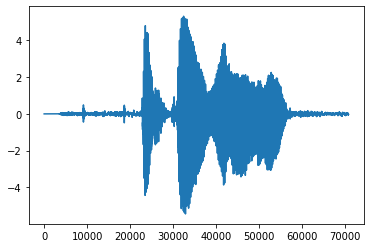

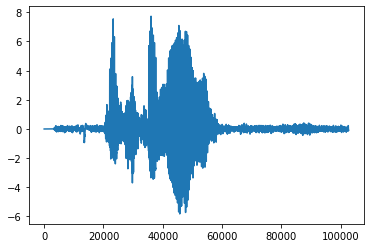

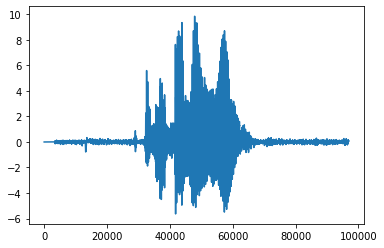

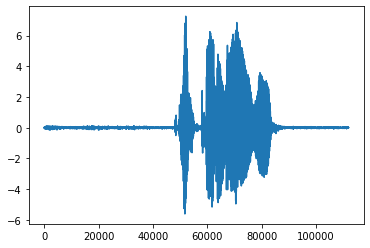

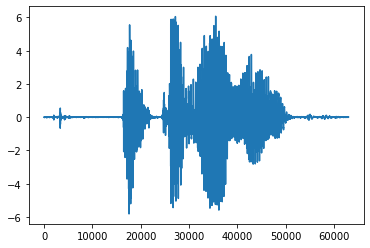

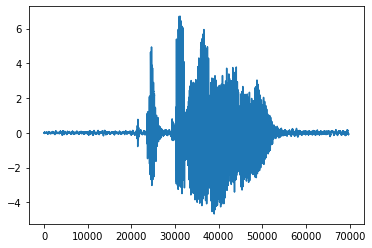

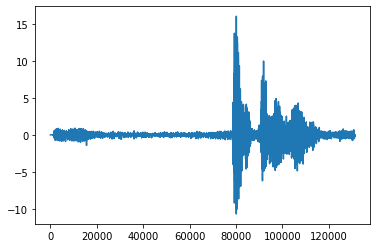

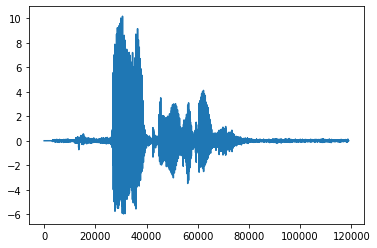

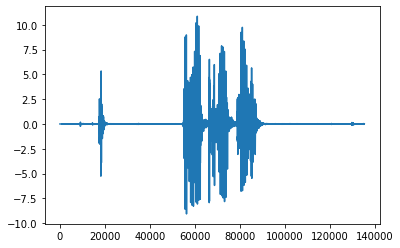

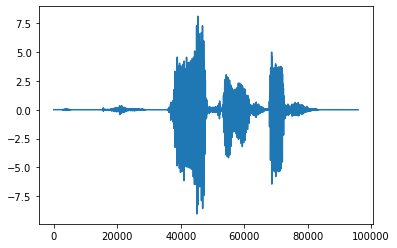

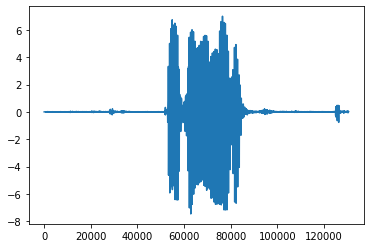

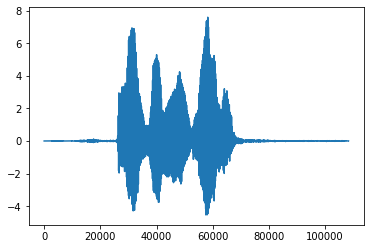

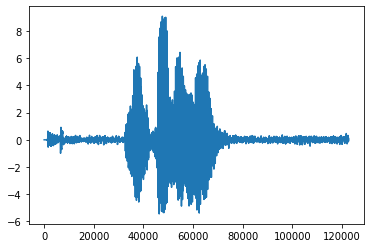

In [3]:
"""Se crea una vector en donde se encuentras las frecuencias de cada audio 
    recolectado. La frecuencia es sacada del primer canal de cada audio. 
"""

audios = []
with os.scandir('audios') as ficheros:
    for fichero in ficheros:
        audios.append(fichero)
sonidos = []
for i in range(len(audios)):
    archivo=audios[i]
    fsonido, sonido = waves.read(archivo)
    channel = sonido[:,0].copy()
    sonido_normalizado = scale( channel, axis=0, with_mean=True, with_std=True, copy=True )
    sonidos.append(sonido_normalizado)
    plt.plot(sonido_normalizado)
    plt.show()

Así mismo se realizará con los ruidos de fondo. 

_Los ruidos de fondo escogidos fueron: sonido blanco, tráfico y lluvia._

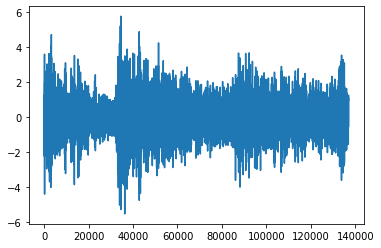

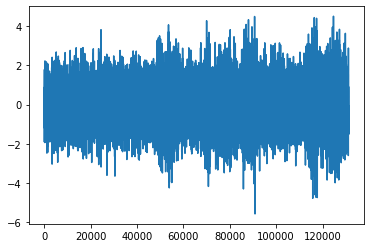

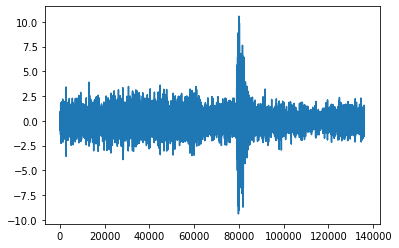

In [4]:
"""Se crea un vector compuesto por las frecuencias de los ruidos escogidos"""
interferencias = []
with os.scandir('Ruidos') as ficheros:
    for fichero in ficheros:
        interferencias.append(fichero)
ruidos = []
for i in range(len(interferencias)):
    archivo=interferencias[i]
    fsonido, sonido = waves.read(archivo)
    channel = sonido[:,0].copy()
    ruido_normalizado = scale(channel, axis=0, with_mean=True, with_std=True, copy=True )
    ruidos.append(ruido_normalizado)
    plt.plot(ruido_normalizado)
    plt.show()


Como se puede ver en las gráficas anteriores, todos los audios tienen una longitud entre _80000_ y _140000_. Por esta razón, por medio de la tranformada de Fourier, comprimiremos todas las señales para que a la hora de ahcer la combinación entre los audios y los ruidos, tengan la misma longitud _(1024)_. 

In [5]:
sonidos_muestra_real=[] #Vector en donde se encontrará la parte de real de la tranformada del vector de frecuencias de sonido
sonidos_muestra_imag=[] #Vector en donde se encontrará la parte de imaginaria de la tranformada del vector de frecuencias de sonido
ruidos_muestra_real=[] #Vector en donde se encontrará la parte de real de la tranformada del vector de frecuencias de ruido
ruidos_muestra_imag=[] #Vector en donde se encontrará la parte de imaginaria de la tranformada del vector de frecuencias de sonido

for sonido in sonidos:
    sonidos_muestra_real.append(np.real(fft(sonido,512)))
    sonidos_muestra_imag.append(np.imag(fft(sonido,512)))
for ruido in ruidos:
    ruidos_muestra_real.append(np.real(fft(ruido,512)))
    ruidos_muestra_imag.append(np.imag(fft(ruido,512)))

In [6]:
"""Creamos un vector de número aleatorios, 
    los cuales le darán cierta variabilidad a los sonidos, 
    esto con el fin de obtener mas datos. """
vec_sonidos = np.random.rand(5) 
vec_ruidos = []
for i in vec_sonidos:
    vec_ruidos.append(1-i)

In [7]:
"""Se combinan los pesos con cada audio y con cada ruido.
    De manera que obtenemos un total de 255 audios."""
audios_real=[] #La combinación del audio con los pesos. Solo la parte real
audios_imag=[] #La combinación del audio con los pesos. Solo la parte imaginaria
ruidos_real=[] #La combinación del ruido con los pesos. Solo la parte real
ruidos_imag=[] #La combinación del ruido con los pesos. Solo la parte imaginaria
for x in range(len(sonidos)):
    for y in range(len(vec_sonidos)):
        audios_real.append(sonidos_muestra_real[x]*vec_sonidos[y])
        audios_imag.append(sonidos_muestra_imag[x]*vec_sonidos[y])
for x in range(len(ruidos)):
    for y in range(len(vec_ruidos)):
        ruidos_real.append(ruidos_muestra_real[x]*vec_ruidos[y])
        ruidos_imag.append(ruidos_muestra_imag[x]*vec_ruidos[y])

indicadores_ruidos=[[0,5,10],[1,6,11],[2,7,12],[3,8,13],[4,9,14]]
indicadores_audios=[]
for x in range(5):
    mini_indicador=[]
    for n in range(15):
        mini_indicador.append(x+(n*5))
    indicadores_audios.append(mini_indicador)
muestra_reales = []
muestra_imag = []
for x in range(5):
    for ind in indicadores_audios[x]:
        for indi in indicadores_ruidos[x]:
            muestra_reales.append(np.add(audios_real[ind],ruidos_real[indi]))
            muestra_imag.append(np.add(audios_imag[ind],ruidos_imag[indi]))
            

Una vez combinados los audios, queremos tener combinar los audios con el ruido de fondo para así empezar a entrenar las redes neuronales.

In [8]:
muestra = []
for i in range(len(muestra_reales)):
    muestra.append(np.append(muestra_reales[i],muestra_imag[i]))
final = np.array(muestra)

Ahora, empezaremos a crear la red neuronal. Primero se mirará la salida que esta tendrá.

In [9]:
obs_real = []
obs_imag = []
for i in range(5):
    for j in range(len(sonidos)):
        for i in range(3):
            obs_real.append(sonidos_muestra_real[j])
            obs_imag.append(sonidos_muestra_imag[j])
observaciones = []
for i in range(len(obs_real)):
    observaciones.append(np.append(obs_real[i], obs_imag[i]))
obs= np.array(observaciones)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(final, obs, test_size=0.3, random_state=42)

(157, 1024)

In [18]:
#Red neuronal
network = models.Sequential()
network.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.000001), input_shape=(1024,)))
network.add(layers.Dense(512,kernel_regularizer=regularizers.l1(0.000001)))
network.add(layers.Dense(256,kernel_regularizer=regularizers.l2(0.000001)))
network.add(layers.Dense(512,kernel_regularizer=regularizers.l1(0.000001)))
network.add(layers.Dense(1024,kernel_regularizer=regularizers.l2(0.000001)))
network.compile(optimizer = 'rmsprop',loss='mse',metrics=['mae'])
history=network.fit(X_train,y_train,epochs=200,validation_split=0.3)

Epoch 1/200
4/4 [==============================] - 2s 166ms/step - loss: 486.6979 - mae: 12.5490 - val_loss: 41.4564 - val_mae: 3.5809
Epoch 2/200
4/4 [==============================] - 0s 63ms/step - loss: 34.5867 - mae: 3.1773 - val_loss: 5.0715 - val_mae: 1.3646
Epoch 3/200
4/4 [==============================] - 0s 50ms/step - loss: 5.6579 - mae: 1.4873 - val_loss: 2.6614 - val_mae: 1.0777
Epoch 4/200
4/4 [==============================] - 0s 50ms/step - loss: 7.1846 - mae: 1.6296 - val_loss: 3.5649 - val_mae: 1.1974
Epoch 5/200
4/4 [==============================] - 0s 51ms/step - loss: 8.5578 - mae: 1.7238 - val_loss: 28.4877 - val_mae: 3.0681
Epoch 6/200
4/4 [==============================] - 0s 50ms/step - loss: 18.1262 - mae: 2.5257 - val_loss: 7.7111 - val_mae: 1.7868
Epoch 7/200
4/4 [==============================] - 0s 51ms/step - loss: 10.3627 - mae: 1.9140 - val_loss: 6.3920 - val_mae: 1.7459
Epoch 8/200
4/4 [==============================] - 0s 52ms/step - loss: 9.1471 - 

4/4 [==============================] - 0s 52ms/step - loss: 0.6331 - mae: 0.4229 - val_loss: 0.5117 - val_mae: 0.3986
Epoch 64/200
4/4 [==============================] - 0s 53ms/step - loss: 1.2576 - mae: 0.6513 - val_loss: 1.0755 - val_mae: 0.5865
Epoch 65/200
4/4 [==============================] - 0s 57ms/step - loss: 2.4718 - mae: 0.8885 - val_loss: 2.9947 - val_mae: 1.0646
Epoch 66/200
4/4 [==============================] - 0s 59ms/step - loss: 3.5801 - mae: 1.1531 - val_loss: 2.2153 - val_mae: 0.8398
Epoch 67/200
4/4 [==============================] - 0s 54ms/step - loss: 4.0526 - mae: 1.1305 - val_loss: 1.1823 - val_mae: 0.6572
Epoch 68/200
4/4 [==============================] - 0s 52ms/step - loss: 2.2513 - mae: 0.8872 - val_loss: 0.6197 - val_mae: 0.4774
Epoch 69/200
4/4 [==============================] - 0s 54ms/step - loss: 0.4848 - mae: 0.4143 - val_loss: 0.0896 - val_mae: 0.1600
Epoch 70/200
4/4 [==============================] - 0s 55ms/step - loss: 0.2257 - mae: 0.2760 - 

4/4 [==============================] - 0s 51ms/step - loss: 0.0500 - mae: 0.0894 - val_loss: 0.0482 - val_mae: 0.0794
Epoch 126/200
4/4 [==============================] - 0s 53ms/step - loss: 0.0474 - mae: 0.0787 - val_loss: 0.0519 - val_mae: 0.0883
Epoch 127/200
4/4 [==============================] - 0s 54ms/step - loss: 0.0479 - mae: 0.0810 - val_loss: 0.0942 - val_mae: 0.1524
Epoch 128/200
4/4 [==============================] - 0s 52ms/step - loss: 0.7556 - mae: 0.4494 - val_loss: 0.2406 - val_mae: 0.2541
Epoch 129/200
4/4 [==============================] - 0s 53ms/step - loss: 0.2341 - mae: 0.2555 - val_loss: 0.1616 - val_mae: 0.2067
Epoch 130/200
4/4 [==============================] - 0s 53ms/step - loss: 0.1831 - mae: 0.2115 - val_loss: 0.5599 - val_mae: 0.3666
Epoch 131/200
4/4 [==============================] - 0s 56ms/step - loss: 0.3756 - mae: 0.2856 - val_loss: 0.0573 - val_mae: 0.1007
Epoch 132/200
4/4 [==============================] - 0s 55ms/step - loss: 0.0588 - mae: 0.

4/4 [==============================] - 0s 54ms/step - loss: 0.0833 - mae: 0.1482 - val_loss: 0.0428 - val_mae: 0.0569
Epoch 188/200
4/4 [==============================] - 0s 53ms/step - loss: 0.0433 - mae: 0.0621 - val_loss: 0.0692 - val_mae: 0.1280
Epoch 189/200
4/4 [==============================] - 0s 53ms/step - loss: 0.1585 - mae: 0.2166 - val_loss: 0.1211 - val_mae: 0.1845
Epoch 190/200
4/4 [==============================] - 0s 50ms/step - loss: 0.1030 - mae: 0.1753 - val_loss: 0.1057 - val_mae: 0.1740
Epoch 191/200
4/4 [==============================] - 0s 52ms/step - loss: 0.1499 - mae: 0.2191 - val_loss: 0.1335 - val_mae: 0.2058
Epoch 192/200
4/4 [==============================] - 0s 50ms/step - loss: 0.1527 - mae: 0.2309 - val_loss: 0.0938 - val_mae: 0.1643
Epoch 193/200
4/4 [==============================] - 0s 53ms/step - loss: 0.0898 - mae: 0.1611 - val_loss: 0.2092 - val_mae: 0.2519
Epoch 194/200
4/4 [==============================] - 0s 53ms/step - loss: 0.1797 - mae: 0.

In [12]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


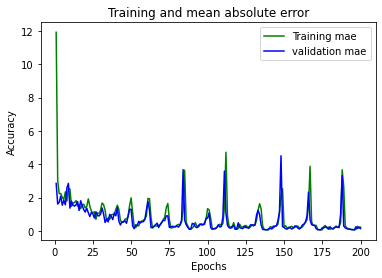

In [15]:
loss_train = history.history['mae']
loss_val = history.history['val_mae']
epochs = range(1,201)
plt.plot(epochs, loss_train, 'g', label='Training mae')
plt.plot(epochs, loss_val, 'b', label='validation mae')
plt.title('Training and mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [17]:
test_loss, test_acc = network.evaluate(X_test,y_test)
print('test_mae:', test_acc)

3/3 [==============================] - 0s 13ms/step - loss: 0.0702 - mae: 0.1256
test_mae: 0.12561319768428802


Ahora bien, ahora implementaremos una función en la que el usuario pueda ingresar un audio __.wav__

El audio no tendrá el ruido def ondo incorporado sino, el programa sobrepondrá un ruido existente en la abse de datos de manera aleatoria. Cabe recalcar que el __audio debe estar en la misma carpeta de este docuemento para ser leída.__

In [19]:
def filtro_sonido(Audio):
    fsonido, sonido = waves.read(Audio)
    channel = sonido[:,0].copy()
    audio_normalizado = scale( channel, axis=0, with_mean=True, with_std=True, copy=True )
    plt.plot(audio_normalizado)
    plt.show()
    ruido_funcion = ruidos[random.randrange(0, 2, 1)]
    sonidos_muestra_real_prueba = np.real(fft(audio_normalizado,512))
    sonidos_muestra_imag_prueba = np.imag(fft(audio_normalizado,512))
    ruidos_muestra_real_prueba = np.real(fft(ruido_funcion,512))
    ruidos_muestra_imag_prueba = np.imag(fft(ruido_funcion,512))
    muestra_real_prueba = np.add(sonidos_muestra_real_prueba,ruidos_muestra_real_prueba)
    muestra_imag_prueba = np.add(sonidos_muestra_imag_prueba,ruidos_muestra_imag_prueba)
    muestra_prueba= np.append(muestra_real_prueba,muestra_imag_prueba)
    M=[]
    M.append(muestra_prueba)
    muestra = np.array(M)
    resultado = network.predict(muestra)
    resultado_real = []
    resultado_imag = []
    for i in range(len(resultado[0])):
        if i <512:
            resultado_real.append(resultado[0][i])
        else:
            resultado_imag.append(resultado[0][i]*1j)
    res=[]
    for i in range(len(resultado_real)):
        res.append(resultado_real[i]+resultado_imag[i])
    res_ifft = np.fft.ifft(res,len(channel))
    plt.plot(np.real(res_ifft))
    plt.show
    return resultado 

Lo probaremos con audio existente en la base de datos creada.

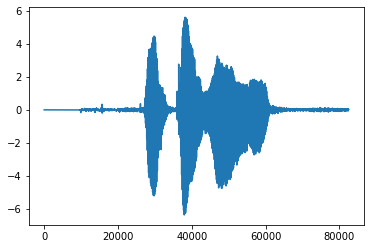

array([[ 0.49794242,  0.13029325, -0.2329188 , ...,  0.4806797 ,
        -0.25050208, -0.3585043 ]], dtype=float32)

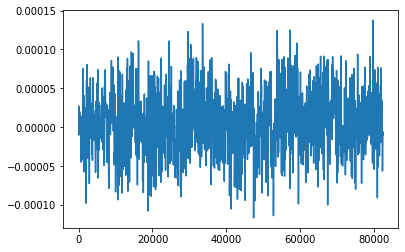

In [20]:
filtro_sonido(audios[1])

## Preguntas

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
- Por el comportamiento de la red, podemos intuir que la red neuronal logra filtrar el audio del ruido de fondo. Al entrenar la red, podemos evidenciar como va diminuyendo el error medio por cada época que va pasando. Asimismo, en donde más se evidencia el cambio es en _val_loss_. Por otro lado, en la gráfica podemos ver el comportamiento del error absoluto medio como disminuye aunque en algunos puntos tenga ciertos picos. 
2. ¿Qué criterio utilizó para seleccionar la arquitectura de la red?
- Dada la información que nos dio el profesor, escogimos el número de neuronas en cada capa en potencia de 2. Además, decidimos que para mayor efectividad computacional, todo tuviera una longitud en potencia de 2. Por otro lado, utilizamos 5 capas en donde en cada capa, había _[1024,512,256,512,1024]_ neuronas respectivamente. Dado que no sabíamos el comportamiento de los valores de las variables, la función de activación que se usó en cada capa fue la función lineal.
3. ¿Tiene la red el comportamiento esperado?, si no es así, ¿A qué cree que se debe esto?
- Como dijimos anteriormente, se logró que el error y la pérdida disminuyera considerablemente, que era uno de los objetivos principales del proyecto.  Esto se da por la cantidad regularizadores con los que se trabaja. Los regularizadores hacen que la neurona no interiorice completamente el procedimiento de por medio, para lograr quitar el ruido de fondo. En otras palabras, evita que las neuronas aprendan el procedimiento de por medio. Sin embargo, al reproducir la señal sin ruido, no se logró la respuesta esperada dado que el comportamiento que la señal tenía, no concordaba con como debía hacerlo. Aún así, obtuvimos un buen valor de error medio. 
4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?
- Con mas número de muestras, se podría sacar mas provecho dado que el número de colecciones es mayor a de las muestras. Por otro lado, podríamos mejorar en la implementación del código de manera en que quede más generalizado y computacionalmente más óptimo. 

## Bibliografía

- https://programmerclick.com/article/8612994366/
- https://pybonacci.org/2012/09/29/transformada-de-fourier-discreta-en-python-con-scipy/
- https://pypi.org/project/scikits.audiolab/
- http://blog.espol.edu.ec/telg1001/audio-en-formato-wav/
- https://realpython.com/playing-and-recording-sound-python/
- https://programmerclick.com/article/47821716307/
